# Monowai CC tests

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from glob import glob
import os
import xcorr

In [2]:
%matplotlib notebook

## Merge files

In [3]:
dest = '../data/results/'

In [4]:
ncfiles = []
for root, dirs, files in os.walk(dest):
    path = root.split(os.sep)
    # print((len(path) - 1) * '---', os.path.basename(root))
    for file in files:
        # print(len(path) * '---', file)
        if file[1] != '.' and file[-3:] == '.nc':
            ncfiles += [os.path.join(root,file)]

In [5]:
sorted(ncfiles)

['../data/results/IM.H03S1..EDH-IU.RAR.10.BHR/IM.H03S1..EDH-IU.RAR.10.BHR.2015.014.nc',
 '../data/results/IM.H03S1..EDH-IU.RAR.10.BHR/IM.H03S1..EDH-IU.RAR.10.BHR.2015.015.nc',
 '../data/results/IM.H03S1..EDH-IU.RAR.10.BHR/IM.H03S1..EDH-IU.RAR.10.BHR.2015.016.nc',
 '../data/results/IM.H03S1..EDH-IU.RAR.10.BHR/IM.H03S1..EDH-IU.RAR.10.BHR.2015.017.nc',
 '../data/results/IM.H03S1..EDH-IU.RAR.10.BHR/IM.H03S1..EDH-IU.RAR.10.BHR.2015.018.nc',
 '../data/results/IM.H03S1..EDH-IU.RAR.10.BHZ/IM.H03S1..EDH-IU.RAR.10.BHZ.2015.014.nc',
 '../data/results/IM.H03S1..EDH-IU.RAR.10.BHZ/IM.H03S1..EDH-IU.RAR.10.BHZ.2015.015.nc',
 '../data/results/IM.H03S1..EDH-IU.RAR.10.BHZ/IM.H03S1..EDH-IU.RAR.10.BHZ.2015.016.nc',
 '../data/results/IM.H03S1..EDH-IU.RAR.10.BHZ/IM.H03S1..EDH-IU.RAR.10.BHZ.2015.017.nc',
 '../data/results/IM.H03S1..EDH-IU.RAR.10.BHZ/IM.H03S1..EDH-IU.RAR.10.BHZ.2015.018.nc',
 '../data/results/IM.H10N1..EDH-IU.RAR.10.BHR/IM.H10N1..EDH-IU.RAR.10.BHR.2015.014.nc',
 '../data/results/IM.H10N1..EDH-

In [6]:
dsets = xcorr.merge(sorted(ncfiles), extract=False, fast=True)

In [9]:
xcorr.bias_correct(dsets)

In [10]:
dsets

<xarray.Dataset>
Dimensions:      (lag: 1080000, pair: 4, time: 40)
Coordinates:
  * pair         (pair) object 'IM.H03S1..EDH-IU.RAR.10.BHR' ... 'IM.H10N1..EDH-IU.RAR.10.BHZ'
  * time         (time) datetime64[ns] 2015-01-14 ... 2015-01-18T21:00:00
  * lag          (lag) timedelta64[ns] 00:00:00 ... 05:59:59.980000
Data variables:
    distance     (pair) float64 7.315e+03 7.315e+03 1.399e+04 1.399e+04
    status       (pair, time) int8 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
    pair_offset  (pair, time) timedelta64[ns] 00:00:00.005500 ... 00:00:00.005500
    time_offset  (pair, time) timedelta64[ns] 00:00:00 00:00:00 ... 00:00:00
    cc           (pair, time, lag) float32 -0.00071950286 ... 0.0034145357
    w            (lag) float64 1.0 1.0 1.0 1.0 1.0 ... 1.333 1.333 1.333 1.333
Attributes:
    title:                 Monowai Volcanic Centre Crosscorrelations - 2015.0...
    institution:           Delft University of Technology, Department of Geos...
    author:                Pieter Smets - P.S.M.Smets@tudelft.nl
    source:                CTBTO/IMS hydroacoustic data and IRIS/USGS seismic...
    history:               Merged @ 2020-04-03 14:18:59.303060, Bias correcte...
    references:            Bendat, J. Samuel, & Piersol, A. Gerald. (1971). R...
    comment:               n/a
    Conventions:           CF-1.9
    xcorr_version:         0.1.dev101+ge822bd0
    dependencies_version:  json-2.0.9, numpy-1.16.4, obspy-1.1.0, pandas-1.0....
    sha256_hash_metadata:  8a32a4f5dd956a290c3eac0e1c938e35d908e17592233624a9...

### Filter

In [19]:
xcorr.signal.filter(dsets.cc, frequency=3., btype='highpass', order=2, inplace=True)

In [25]:
dsets.cc.history

'xcorr-0.1.dev109+g941d3c8: filter({"x":"cc","frequency":3.0,"btype":"highpass","order":2,"dim":"lag","inplace":true,"**kwargs":{}})'

<IPython.core.display.Javascript object>


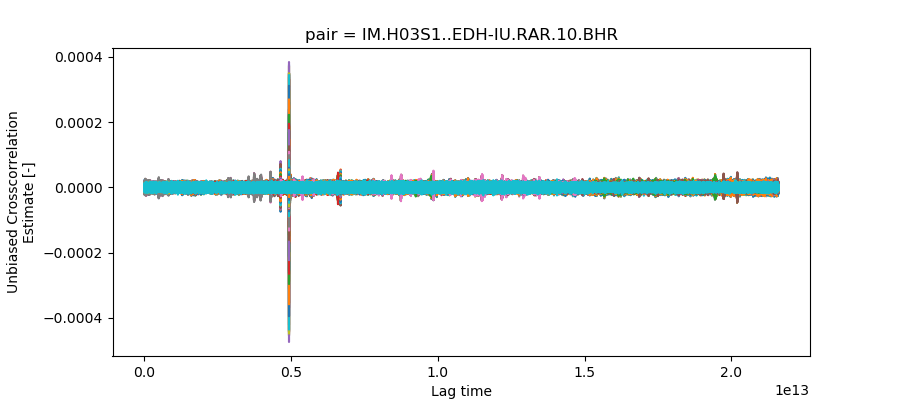

In [24]:
plt.figure(figsize=[9,4])
dsets.cc.loc[{'pair':dsets.pair[0]}].plot.line(x='lag',add_legend=False)

In [20]:
vel = dict(min=1.45, max=1.50)

In [21]:
signal_mask = xcorr.signal.multi_mask(
    x=dsets.lag, y=dsets.distance,
    lower=vel['min'], upper=vel['max'], invert=True,
)

In [26]:
signal_mask.history

'xcorr-0.1.dev109+g941d3c8: multi_mask({"x":"lag (lag)","y":"distance (pair)","lower":1.45,"upper":1.5,"invert":true,"name":null})'

<IPython.core.display.Javascript object>


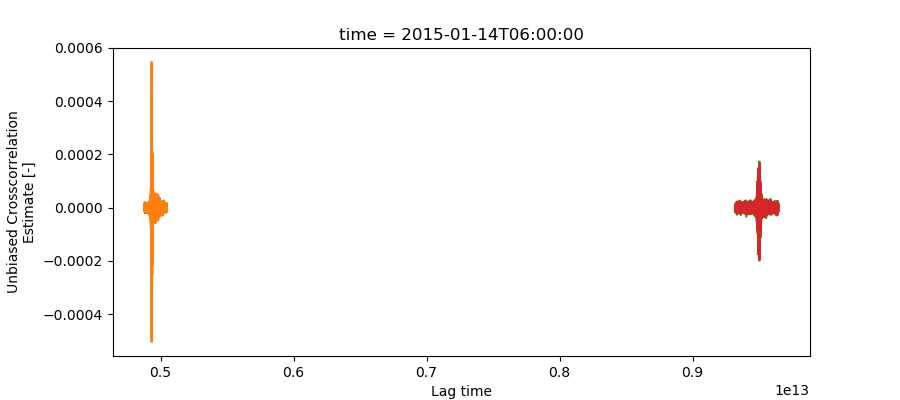

In [23]:
plt.figure(figsize=[9,4])
dsets.cc.where(signal_mask).loc[{'time':dsets.time[2]}].plot.line(x='lag',add_legend=False)

In [27]:
noise_mask = xcorr.signal.mask(
    x=dsets.lag, lower=.2, scalar=dsets.time.window_length, invert=False,
)

In [28]:
noise_mask.history

'xcorr-0.1.dev109+g941d3c8: mask({"x":"lag (lag)","lower":0.2,"upper":null,"scalar":86400.0,"invert":false,"name":null,"to_where":false,"**kwargs":{}})'

<IPython.core.display.Javascript object>


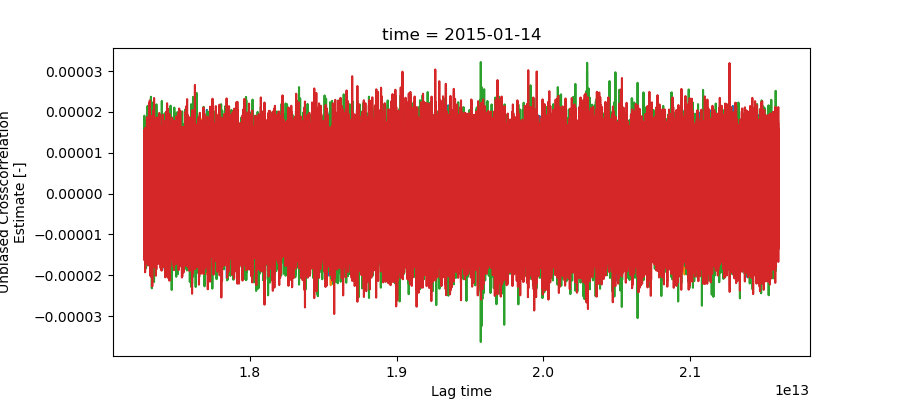

In [29]:
plt.figure(figsize=[9,4])
dsets.cc.where(noise_mask).loc[{'time':dsets.time[0]}].plot.line(x='lag',add_legend=False)

In [30]:
dsets['snr'] = xcorr.signal.snr(dsets.cc,signal=signal_mask,noise=noise_mask,dim='lag')

In [31]:
dsets

<xarray.Dataset>
Dimensions:      (lag: 1080000, pair: 4, time: 40)
Coordinates:
  * pair         (pair) object 'IM.H03S1..EDH-IU.RAR.10.BHR' ... 'IM.H10N1..EDH-IU.RAR.10.BHZ'
  * time         (time) datetime64[ns] 2015-01-14 ... 2015-01-18T21:00:00
  * lag          (lag) timedelta64[ns] 00:00:00 ... 05:59:59.980000
    coord        (pair) <U27 'IM.H03S1..EDH-IU.RAR.10.BHR' ... 'IM.H10N1..EDH-IU.RAR.10.BHZ'
Data variables:
    distance     (pair) float64 7.315e+03 7.315e+03 1.399e+04 1.399e+04
    status       (pair, time) int8 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
    pair_offset  (pair, time) timedelta64[ns] 00:00:00.005500 ... 00:00:00.005500
    time_offset  (pair, time) timedelta64[ns] 00:00:00 00:00:00 ... 00:00:00
    cc           (pair, time, lag) float32 -6.3476405e-06 ... -4.7419798e-07
    w            (lag) float64 1.0 1.0 1.0 1.0 1.0 ... 1.333 1.333 1.333 1.333
    snr          (pair, time) float32 6.299768 5.829934 ... 1.1749951 1.421906
Attributes:
    title:                 Monowai Volcanic Centre Crosscorrelations - 2015.0...
    institution:           Delft University of Technology, Department of Geos...
    author:                Pieter Smets - P.S.M.Smets@tudelft.nl
    source:                CTBTO/IMS hydroacoustic data and IRIS/USGS seismic...
    history:               Merged @ 2020-04-03 14:18:59.303060, Bias correcte...
    references:            Bendat, J. Samuel, & Piersol, A. Gerald. (1971). R...
    comment:               n/a
    Conventions:           CF-1.9
    xcorr_version:         0.1.dev101+ge822bd0
    dependencies_version:  json-2.0.9, numpy-1.16.4, obspy-1.1.0, pandas-1.0....
    sha256_hash_metadata:  8a32a4f5dd956a290c3eac0e1c938e35d908e17592233624a9...

<IPython.core.display.Javascript object>


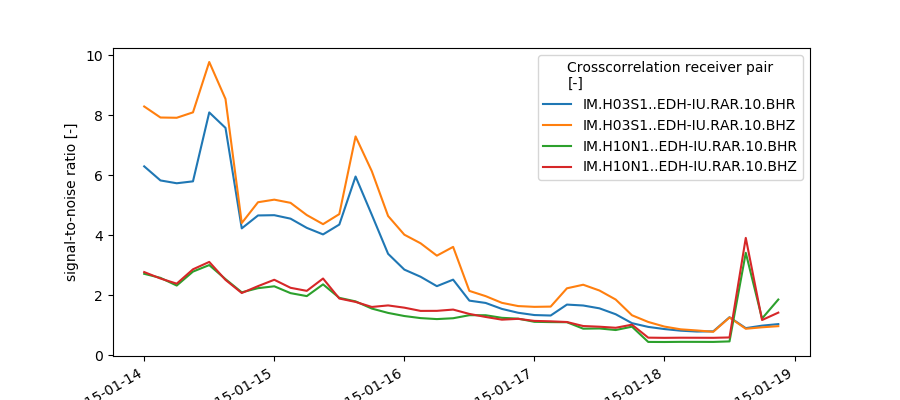

In [32]:
plt.figure(figsize=[9,4])
dsets.snr.plot.line(x='time',add_legend=True)